In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re

In [3]:
df = pd.read_csv('2012_public_use_data_aug2016.csv')
print(df.shape)
df.dtypes

(6720, 1119)


PUBID        int64
REGION       int64
CENDIV       int64
PBA          int64
FREESTN    float64
            ...   
DHCLBTU    float64
DHWTBTU    float64
DHCKBTU    float64
DHOTBTU    float64
PUBCLIM      int64
Length: 1119, dtype: object

In [7]:
# update with new codebook created from "clean_cbecs2012_codebook.ipynb"
df_codebook = pd.read_csv('grouped_2012microdata_codebook.csv')

Index(['CATEOGORIES', 'File order', 'Variable\r\nname', 'Variable type',
       'Len-\r\ngth', 'Format', 'Label', 'Values/Format codes', 'Unnamed: 8'],
      dtype='object')


,CATEOGORIES,File order,Variable\r\nname,Variable type,Len-\r\ngth,Format,Label,Values/Format codes,Unnamed: 8
0,0,1.0,PUBID,Char,5.0,NaN,Building identifier,00001 - 06720,NaN
1,0,2.0,REGION,Char,1.0,$REGION.,Census region,'1' = 'Northeast'\r\n'2' = 'Midwest'\r\n'3' = ...,NaN
2,0,3.0,CENDIV,Char,1.0,$CENDIV.,Census division,'1' = 'New England'\r\n'2' = 'Middle Atlantic'...,NaN
3,0,4.0,PBA,Char,2.0,$PBA.,Principal building activity,'01' = 'Vacant'\r\n'02' = 'Office'\r\n'04' = '...,NaN
4,1,5.0,FREESTN,Char,1.0,$YES.,Freestanding building,1' = 'Yes'\r\nMissing='No',NaN


## EDA

Separated by Category (1-7, 10)

In [ ]:
df = df.drop(columns=category_map['get rid of'])
print(df.shape)
df.sample(5)

In [ ]:
new_1 = []
for cat_name in category_map['1']:
    if type(cat_name) == str:
        new_1.append(cat_name)
category_map['1'] = np.array(new_1)
category_map['1']

In [ ]:
dfs = {}
for cat_name, cat_list in category_map.items():
    if cat_name != 'get rid of':
        dfs[cat_name] = df[cat_list]
dfs['0'].sample(10)

In [ ]:
test_code_split = category_dfs['0'].drop(['category', 'file_order', 'col_type', 'length', 'format',], axis=1)
test_code_split['code_split'] = test_code_split.codes.str.split('\n')
test_code_split.set_index(keys=test_code_split.col_name, drop=True).T

col_name,PUBID,REGION,CENDIV,PBA
col_name,PUBID,REGION,CENDIV,PBA
col_description,Building identifier,Census region,Census division,Principal building activity
codes,00001 - 06720,'1' = 'Northeast'\n'2' = 'Midwest'\n'3' = 'Sou...,'1' = 'New England'\n'2' = 'Middle Atlantic'\n...,'01' = 'Vacant'\n'02' = 'Office'\n'04' = 'Labo...
code_split,[00001 - 06720],"['1' = 'Northeast', '2' = 'Midwest', '3' = 'So...","['1' = 'New England', '2' = 'Middle Atlantic',...","['01' = 'Vacant', '02' = 'Office', '04' = 'Lab..."


## EDA

Separated by Category (1-7, 10)

In [8]:
df = df.drop(columns=category_map['get rid of'])
print(df.shape)
df.sample(5)

(6720, 516)


,PUBID,REGION,CENDIV,PBA,FREESTN,SQFT,SQFTC,WLCNS,RFCNS,RFCOOL,...,FKCLBTU,FKWTBTU,FKCKBTU,FKOTBTU,DHHTBTU,DHCLBTU,DHWTBTU,DHCKBTU,DHOTBTU,PUBCLIM
782,783,3,7,5,NaN,4000,2,5,6,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
248,249,4,9,13,1.0,1500000,10,3,4,2,...,0.0,0.0,0.0,2999043.0,15909000.0,0.0,0.0,0.0,0.0,7
257,258,3,5,2,NaN,158000,7,2,6,1,...,0.0,0.0,0.0,24608.0,NaN,NaN,NaN,NaN,NaN,2
2641,2642,2,3,13,1.0,9300,3,4,2,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3535,3536,2,3,5,NaN,3000,2,4,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [9]:
new_1 = []
for cat_name in category_map['1']:
    if type(cat_name) == str:
        new_1.append(cat_name)
category_map['1'] = np.array(new_1)
category_map['1']

array(['FREESTN', 'SQFT', 'SQFTC', 'WLCNS', 'RFCNS', 'RFCOOL', 'RFTILT',
       'BLDSHP', 'GLSSPC', 'EQGLSS', 'SUNGLS', 'NFLOOR', 'BASEMNT',
       'FLCEILHT', 'ATTIC', 'ELEVTR', 'NELVTR', 'ESCLTR', 'NESLTR',
       'YRCON', 'YRCONC', 'MONCON', 'RENOV', 'RENADD', 'RENRDC', 'RENCOS',
       'RENINT', 'RENRFF', 'RENWLL', 'RENWIN', 'RENHVC', 'RENLGT',
       'RENPLB', 'RENELC', 'RENINS', 'RENSAF', 'RENSTR', 'RENOTH',
       'ONEACT', 'ACT1', 'ACT2', 'ACT3', 'ACT1PCT', 'ACT2PCT', 'ACT3PCT',
       'PBAPLUS', 'DRYCL', 'VACANT', 'CUBE', 'CUBEC', 'CUBELOC', 'RWSEAT',
       'PBSEAT', 'EDSEAT', 'FDSEAT', 'HCBED', 'NRSBED', 'LODGRM', 'COURT',
       'FACIL', 'FEDFAC', 'FACACT', 'MANIND', 'PLANT', 'FACDST', 'FACDHW',
       'FACDCW', 'FACELC', 'BLDPLT'], dtype='<U8')

In [10]:
dfs = {}
for cat_name, cat_list in category_map.items():
    if cat_name != 'get rid of':
        dfs[cat_name] = df[cat_list]
dfs['0'].sample(10)

,PUBID,REGION,CENDIV,PBA
4242,4243,3,6,12
5503,5504,1,1,18
1782,1783,3,6,2
70,71,4,9,14
878,879,4,8,5
2746,2747,3,5,13
2080,2081,2,4,13
4581,4582,3,5,25
3153,3154,1,2,8
3999,4000,2,3,14


In [11]:
dfs['0'].groupby('CENDIV').size()

CENDIV
1     319
2     787
3     900
4     559
5    1348
6     392
7     852
8     450
9    1113
dtype: int64

### EDA Category 1

Building Attributes - tried to select only continuous variables
1. Square Footage (SQFT) 1,001 - 1,500,000
2. Number of Floors (NFLOOR) 1-14, 994=15-25, 995= >25
3. Year of construction (YRCON) 995=<1946, 1946-2012
4. Any Renovations (RENOV) 1=yes, 2=no

Total Size n = 6720

Grouped by Rennovation status (`NFLOOR`, `SQFT`, `YRCON`) 
- RENOV = 1 
    - n = 3423
    - mean = 47.776220	173371.279287	1826.157172
    - median = 2	42000	1974
    - std = 206.210635	310598.178086	355.687342
- RENOV = 2 
    - n = 2936
    - mean = 11.026226	70129.489441	1883.572548
    - median = 1	10750	1985
    - std = 94.754694	174537.161246	301.333128
- RENOV Missing
    - n = 361
    
Visualizations
- I need to do some more precise manipulation to get a better idea of the spread of the data (i.e. having a hard time visualizing num floors and year constructed due to the flagged variables (994/995)

General Thoughts
- Roughly even distribution of unrennovated/rennovated buildings
- Coded data throws off averages, so better to use medians
- Older buildings without rennovations are larger (sqft/numfloor)
- Younger buildings with rennovations are smaller (sqft/numfloor)

In [12]:
cat1_descriptions = category_dfs['1'][['col_name', 'col_description']].to_dict(orient='records')
cat1_cols_interest_descriptions = ['Square footage', 'Number of floors',  'Year of construction', 'Any renovations',]
cat1_cols_interest = []
for dictionary in cat1_descriptions:
    if dictionary['col_description'] in cat1_cols_interest_descriptions:
        cat1_cols_interest.append(dictionary['col_name'])
        print(dictionary['col_description'])
cat1_cols_interest

#SQFT Codes (Continuous)
#1,001 - 1,500,000


#NFLOOR CODES (both Continuous/Categorical)
#"1 - 14
#994 = 15 to 25
#995 = More than 25"

#YRCON CODES (Mostly Continuous)
#"995 = Before 1946
#1946 - 2012"

#RENOV CODES
#"'1' = 'Yes'
#'2' = 'No'
#Missing = Not applicable"


Square footage
Number of floors
Year of construction
Any renovations


['SQFT', 'NFLOOR', 'YRCON', 'RENOV']

In [13]:
df1 = df[cat1_cols_interest]
df1_total = df1.shape[0]
renov_group = df1.groupby('RENOV').size()
print(df1_total)
print(renov_group)
print(df1_total - (renov_group[1] + renov_group[2]))

In [14]:
df1.pivot_table(index='RENOV', values=['SQFT', 'NFLOOR', 'YRCON'], aggfunc=np.mean)

,NFLOOR,SQFT,YRCON
RENOV,,,
1.0,47.776220,173371.279287,1826.157172
2.0,11.026226,70129.489441,1883.572548


In [15]:
df1.pivot_table(index='RENOV', values=['SQFT', 'NFLOOR', 'YRCON'], aggfunc=np.std)

,NFLOOR,SQFT,YRCON
RENOV,,,
1.0,206.210635,310598.178086,355.687342
2.0,94.754694,174537.161246,301.333128


In [16]:
df1.pivot_table(index='RENOV', values=['SQFT', 'NFLOOR', 'YRCON'], aggfunc=np.min)

,NFLOOR,SQFT,YRCON
RENOV,,,
1.0,1,1050,995
2.0,1,1001,995


In [17]:
df1.pivot_table(index='RENOV', values=['SQFT', 'NFLOOR', 'YRCON'], aggfunc=np.max)

,NFLOOR,SQFT,YRCON
RENOV,,,
1.0,995,1500000,2007
2.0,995,1500000,2007


In [18]:
df1.pivot_table(index='RENOV', values=['SQFT', 'NFLOOR', 'YRCON'], aggfunc=np.median)

,NFLOOR,SQFT,YRCON
RENOV,,,
1.0,2,42000,1974
2.0,1,10750,1985


<AxesSubplot:xlabel='SQFT', ylabel='Count'>

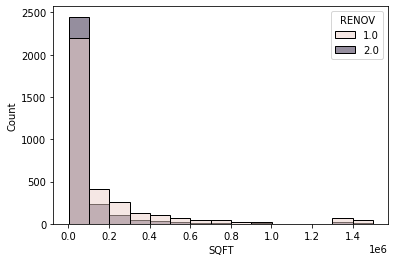

In [19]:
sns.histplot(df1, x='SQFT', binwidth=100000, hue='RENOV')

<AxesSubplot:xlabel='YRCON', ylabel='Count'>

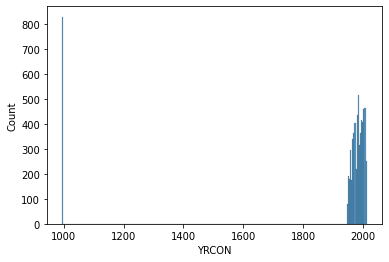

In [20]:
sns.histplot(df1, x='YRCON')

### EDA Category 2

Building Ownership - Not now

In [ ]:
cat2_descriptions = category_dfs['2'][['col_name', 'col_description']].to_dict(orient='records')
cat2_descriptions

### EDA Category 3

Operations

In [ ]:
cat3_descriptions = category_dfs['3'][['col_name', 'col_description']].to_dict(orient='records')
cat3_descriptions

In [ ]:
cat3_cols_interest_descriptions = ['Months in use', 'Percent occupancy',  'Lodging room percent occupancy', 'Total hours open per week', 'Number of employees']
cat3_cols_interest = []
for dictionary in cat3_descriptions:
    if dictionary['col_description'] in cat3_cols_interest_descriptions:
        cat3_cols_interest.append(dictionary['col_name'])
        print(dictionary['col_description'])
cat3_cols_interest

# MONUSE CODES
# 0 - 12

# OCCUPYP, LODOCCP
# 0-100

# WRKHRS
# 0-168

# NWKER
# 0-6500

In [ ]:
df3 = df[cat3_cols_interest]
df3.describe()

In [ ]:
df3.groupby('MONUSE').size()

In [ ]:
df3.pivot_table(index='MONUSE', values=['OCCUPYP', 'LODOCCP', 'WKHRS', 'NWKER'], aggfunc=np.mean)

In [ ]:
df3.pivot_table(index='MONUSE', values=['OCCUPYP', 'LODOCCP', 'WKHRS', 'NWKER'], aggfunc=np.std)

In [ ]:
df3.pivot_table(index='MONUSE', values=['OCCUPYP', 'LODOCCP', 'WKHRS', 'NWKER'], aggfunc=np.min)

In [ ]:
df3.pivot_table(index='MONUSE', values=['OCCUPYP', 'LODOCCP', 'WKHRS', 'NWKER'], aggfunc=np.max)

In [ ]:
df3.pivot_table(index='MONUSE', values=['OCCUPYP', 'LODOCCP', 'WKHRS', 'NWKER'], aggfunc=np.median)

### EDA Category 4

Energy Source / Purpose

In [ ]:
cat4_descriptions = category_dfs['4'][['col_name', 'col_description']].to_dict(orient='records')
cat4_descriptions

### EDA Category 5

Energy Management

In [ ]:
cat5_descriptions = category_dfs['5'][['col_name', 'col_description']].to_dict(orient='records')
cat5_descriptions

### EDA Category 6

Service Industry Characteristics - Not right now

In [ ]:
cat6_descriptions = category_dfs['6'][['col_name', 'col_description']].to_dict(orient='records')
cat6_descriptions

### Category 7

Lighting

In [ ]:
cat7_descriptions = category_dfs['7'][['col_name', 'col_description']].to_dict(orient='records')
cat7_descriptions

### Category 10

Energy Expenses and Consumption

In [ ]:
cat10_descriptions = category_dfs['10'][['col_name', 'col_description']].to_dict(orient='records')
cat10_descriptions